In [2]:
# Cell 1 - imports & helpers
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
import sys

plt.rcParams["figure.figsize"] = (12, 8)


In [3]:
# Cell 2 - load class names
classes_file = Path(r"C:\Users\vedan\Machine Learning\SWE PROJECT\dataset\classes.txt")   # adjust if needed
if not classes_file.exists():
    raise FileNotFoundError(f"classes.txt not found at {classes_file}")
names = []
with open(classes_file, "r", encoding="utf8") as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        parts = s.split(None, 1)
        if len(parts) == 1:
            names.append(parts[0])
        else:
            # if line is "0 class_name" we take the second part
            if parts[0].isdigit():
                names.append(parts[1].strip())
            else:
                names.append(s)
print(f"Loaded {len(names)} class names. Example: {names[:5]}")


Loaded 36 class names. Example: ['Bear', 'Brown bear', 'Buffalo', 'Bull', 'Cattle']


In [5]:
# Cell 3 - load weights
EXP_NAME = "wildlife_yolov8x_10245"   # change if your experiment name differs
run_weights_dir = Path(r"C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\first_run\weights")
best = run_weights_dir / "best.pt"
last = run_weights_dir / "last.pt"

if best.exists():
    WEIGHTS_PATH = str(best)
elif last.exists():
    WEIGHTS_PATH = str(last)
else:
    print("No best.pt / last.pt found in", run_weights_dir)
    # fallback: use a pretrained backbone from ultralytics hub (requires internet)
    WEIGHTS_PATH = "yolov8x.pt"
    print("Falling back to pretrained:", WEIGHTS_PATH)

print("Using weights:", WEIGHTS_PATH)
model = YOLO(WEIGHTS_PATH)   # loads model


Using weights: C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\first_run\weights\best.pt


In [6]:
# Cell 4 - drawing helpers
def draw_boxes_cv2(img, boxes, scores, classes_idx, class_names, color=(255, 180, 0), thickness=2, font_scale=0.6):
    """
    boxes: Nx4 array of xyxy coords (absolute pixel coordinates)
    scores: N scores
    classes_idx: N integers
    class_names: list of class names
    """
    img = img.copy()
    h, w = img.shape[:2]
    for (x1, y1, x2, y2), conf, cls in zip(boxes, scores, classes_idx):
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness, lineType=cv2.LINE_AA)
        label = f"{class_names[int(cls)]} {conf:.2f}"
        # label background
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
        cv2.rectangle(img, (x1, max(0, y1-th-6)), (x1 + tw, y1), color, -1)
        cv2.putText(img, label, (x1, y1-4), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), 1, lineType=cv2.LINE_AA)
    return img

def show_img_cv2(img_bgr):
    # Convert BGR to RGB and show with matplotlib
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img); plt.axis("off")


Detections: [('Zebra', 0.9613704681396484)]


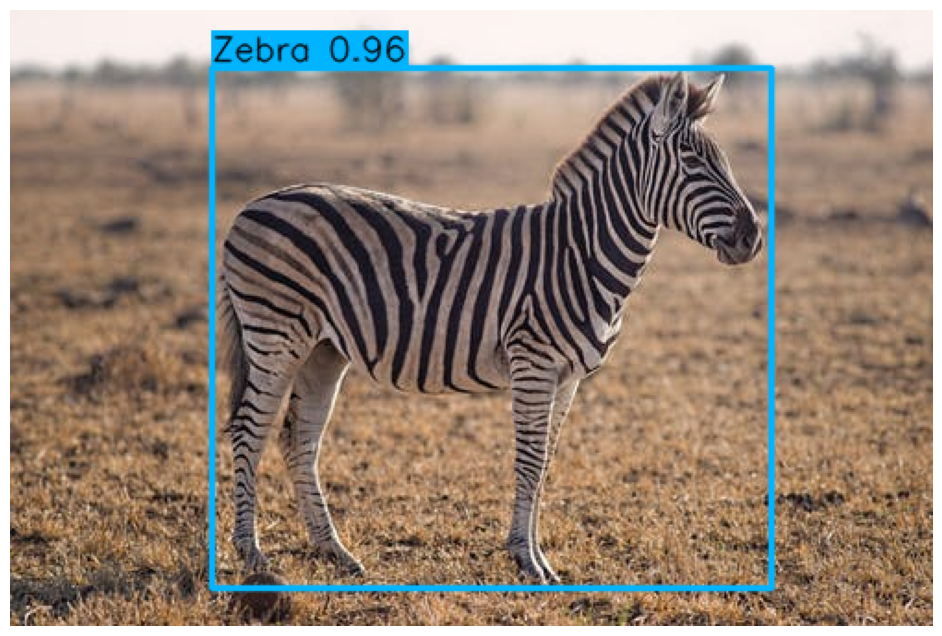

In [10]:
# Cell 5 - single image inference and draw predictions
img_path = Path(r"C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\predictions\Zebra_362.jpg")  # your sample
assert img_path.exists(), f"{img_path} not found"

# run inference (returns a list-like of Results)
res = model.predict(source=str(img_path), conf=0.25, imgsz=1024, device=0, save=False, verbose=False)
# res is a list of length 1 for single image
r = res[0]

# extract boxes, confidences, classes (works for ultralytics results)
boxes_xyxy = r.boxes.xyxy.cpu().numpy() if hasattr(r.boxes, "xyxy") else np.array([])
scores = r.boxes.conf.cpu().numpy() if hasattr(r.boxes, "conf") else np.array([])
cls_idx = r.boxes.cls.cpu().numpy() if hasattr(r.boxes, "cls") else np.array([])

img = cv2.imread(str(img_path))
annot = draw_boxes_cv2(img, boxes_xyxy, scores, cls_idx, names, color=(255,180,0))
show_img_cv2(annot)
print("Detections:", [(names[int(c)], float(s)) for c,s in zip(cls_idx, scores)])


In [ ]:
# # Cell 7 - batch inference in a folder and save annotated images
# src_folder = Path("/dataset/test/images")   # images to run inference on
# out_folder = Path("runs") / "inference" / EXP_NAME / "annotated_images"
# out_folder.mkdir(parents=True, exist_ok=True)

# img_paths = sorted([p for p in src_folder.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
# print("Found", len(img_paths), "images")

# for i, p in enumerate(img_paths):
#     res = model.predict(source=str(p), conf=0.25, imgsz=1024, device=0, save=False, verbose=False)
#     r = res[0]
#     boxes = r.boxes.xyxy.cpu().numpy() if hasattr(r.boxes, "xyxy") else np.array([])
#     scores = r.boxes.conf.cpu().numpy() if hasattr(r.boxes, "conf") else np.array([])
#     cls_idx = r.boxes.cls.cpu().numpy() if hasattr(r.boxes, "cls") else np.array([])
#     img = cv2.imread(str(p))
#     annotated = draw_boxes_cv2(img, boxes, scores, cls_idx, names)
#     outp = out_folder / p.name
#     cv2.imwrite(str(outp), annotated)
#     if (i+1) % 50 == 0:
#         print("Processed", i+1)
# print("Annotated images saved to:", out_folder.resolve())


In [15]:
# Cell 8 - automatic video annotation (fast to use)
video_in = r"C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\predictions\rhino.mp4"   # change to your file
video_out_dir = Path(r"C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\predictions") / "inference"/"annotated_videos"
video_out_dir.mkdir(parents=True, exist_ok=True)

# Ultralytics will write an annotated video file into save_dir
res = model.predict(source=video_in, show=False, save=True, save_dir=str(video_out_dir), conf=0.25, imgsz=1024)
print("Ultralytics saved annotated outputs to:", video_out_dir)
# The annotated file will appear with same base name inside the directory.


WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to runs\detect\predict
Ultralytics saved annotated outputs to: C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\predictions\inference\annotated_videos


In [17]:
# Cell 9 - custom frame-by-frame processing (slower but more flexible)
video_in = r"C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\predictions\rhino.mp4"
video_out = Path(r"C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\predictions") / "inference"/"annotated_videos/prediction.mp4"
video_out.parent.mkdir(parents=True, exist_ok=True)

cap = cv2.VideoCapture(video_in)
fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(video_out), fourcc, fps, (width, height))

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # feed frame to model (Ultralytics accepts np.ndarray)
    results = model.predict(source=frame, conf=0.25, imgsz=1024, device=0, save=False, verbose=False)
    r = results[0]
    boxes = r.boxes.xyxy.cpu().numpy() if hasattr(r.boxes, "xyxy") else np.array([])
    scores = r.boxes.conf.cpu().numpy() if hasattr(r.boxes, "conf") else np.array([])
    cls_idx = r.boxes.cls.cpu().numpy() if hasattr(r.boxes, "cls") else np.array([])

    annotated_frame = draw_boxes_cv2(frame, boxes, scores, cls_idx, names)
    writer.write(annotated_frame)

    frame_idx += 1
    if frame_idx % 100 == 0:
        print("Processed frames:", frame_idx)

cap.release()
writer.release()
print("Custom annotated video saved to:", video_out.resolve())


Processed frames: 100
Processed frames: 200
Processed frames: 300
Processed frames: 400
Processed frames: 500
Processed frames: 600
Processed frames: 700
Processed frames: 800
Processed frames: 900
Processed frames: 1000
Processed frames: 1100
Processed frames: 1200
Processed frames: 1300
Processed frames: 1400
Processed frames: 1500
Processed frames: 1600
Processed frames: 1700
Processed frames: 1800
Processed frames: 1900
Processed frames: 2000
Processed frames: 2100
Processed frames: 2200
Processed frames: 2300
Custom annotated video saved to: C:\Users\vedan\Machine Learning\SWE PROJECT\new_after_midsem\predictions\inference\annotated_videos\prediction.mp4
